In [14]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

import cv2 as cv
from scipy import ndimage as ndi

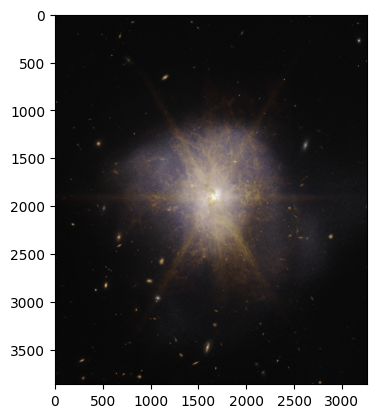

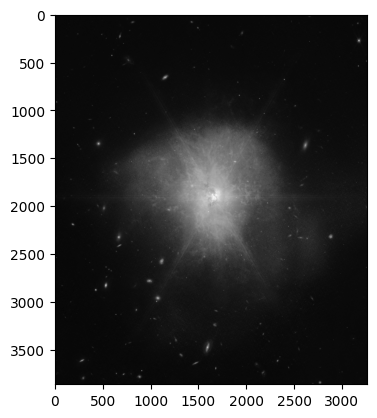

In [15]:
# criando o path de ler imagem, localizado em tests/data/galaxy

current_path = os.getcwd()
# subindo uma folder para acessar a pasta data
current_path = os.path.abspath(os.path.join(current_path, os.pardir))
# descendo um folder para data/galaxy
current_path = os.path.join(current_path, 'data', 'galaxy')
# acessando o arquivo arq220.tif
img_path = 'arp220.tif'

path = os.path.join(current_path, img_path)

# lendo a imagem 'quintet.tif'
img = tiff.imread(path)

img_array = np.array(img)

gray = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)

plt.imshow(img_array)
plt.show()

plt.imshow(gray, cmap="gray")
plt.show()

In [16]:
h, w = gray.shape
print(h, w)

3864 3267


## pronto para aplicar a transformada de fourier

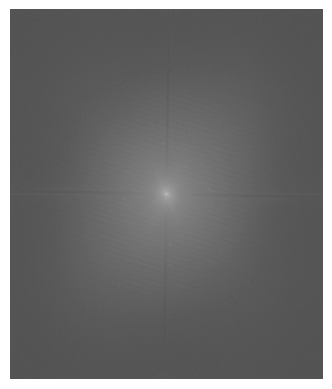

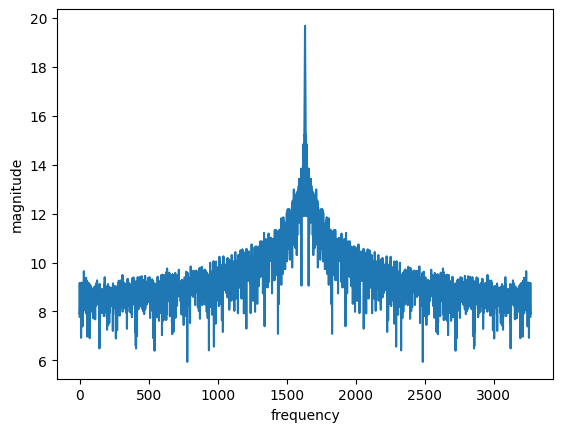

In [4]:
img_copy = gray.copy()

f_transform = np.fft.fft2(img_copy)
f_transform = np.fft.fftshift(f_transform)

magnitude_spectrum = np.abs(f_transform)
magnitude_spectrum = np.log(1+magnitude_spectrum)

height, width = magnitude_spectrum.shape
horizontal_profile = magnitude_spectrum[height//2, :]

plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')
plt.show()

plt.plot(horizontal_profile)
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.show()

In [5]:
max(horizontal_profile)

19.662917866731938

In [6]:
min(horizontal_profile)

5.940769870766988

In [7]:
magnitude_spectrum.min()

1.080450013105729

In [8]:
magnitude_spectrum.max()

19.662917866731938

## fazendo filtro passa banda

In [23]:
class Observar:

    def __init__(self, input_img,f_max,f_min,**kwargs):  
        self.input = np.array(input_img)
        self.fmax = f_max
        self.fmin = f_min
        self.alfa = kwargs.get('alfa', 0.5)
        self.beta = kwargs.get('beta', 0.5)
        self.dpi = kwargs.get('dpi', 100)
        self.img_show_tuple = kwargs.get('img_show_tuple', (10, 10))
        self.gausian_sigma = kwargs.get('gausian_sigma', 5)
        self.skleton_treshold = kwargs.get('skleton_treshold', 127)
        self.skleton_morphology = kwargs.get('skleton_morphology', cv.MORPH_CROSS)
        self.skleton_kernel = kwargs.get('skleton_kernel', np.ones((3,3),np.uint8))
        self.save_img = kwargs.get('save_img', False)
    
    def gray(self):
        self.gray_img = cv.cvtColor(self.input, cv.COLOR_BGR2GRAY)

    def fourier(self):
        # Starting the pipeline
        f_transform = np.fft.fft2(self.gray_img)
        self.f_transform = np.fft.fftshift(f_transform)

        magnitude_spectrum = np.abs(self.f_transform)
        magnitude_spectrum = np.log(1 + magnitude_spectrum)
        self.magnitude_spectrum = magnitude_spectrum
    
    def horizontal_profile(self):
        height, _ = self.magnitude_spectrum.shape
        horizontal_profile = self.magnitude_spectrum[height // 2, :]
        self.horizontal_profile = horizontal_profile
        
    def mask(self):
        self.rows, self.cols = self.gray_img.shape
        crow, ccol = self.rows // 2, self.cols // 2
        mask = self.magnitude_spectrum.copy()

        l, c = np.indices((self.rows, self.cols))
        distances = np.sqrt((l - crow) ** 2 + (c - ccol) ** 2)
        mask = np.where((distances > self.fmax) | (distances < self.fmin), 0, mask)

        # Applying Gaussian smoothing to the mask
        self.mask = ndi.gaussian_filter(mask, sigma=self.gausian_sigma)
    
    def fourier_inverse(self):
        # Apply the mask
        self.f_transform *= self.mask
        # Inverse FFT
        f_ishift = np.fft.ifftshift(self.f_transform)
        img_back = np.fft.ifft2(f_ishift)
        self.img_back = np.abs(img_back)

    def sobel(self):
        # Apply the Sobel filter
        dx = ndi.sobel(self.img_back, 0)
        dy = ndi.sobel(self.img_back, 1)
        mag = np.hypot(dx, dy)
        mag *= 255.0 / np.max(mag)
        self.mag = mag
    
    def skeletonize(self):
        # Threshold the image
        ret,img = cv.threshold(self.mag, self.skleton_treshold, 255, 0)
        size = np.size(img)
        skel = np.zeros(img.shape, np.uint8)
        element = cv.getStructuringElement(self.skleton_morphology, self.skleton_kernel)


    def blend(self):
        # Blend the Sobel output with the original image
        sobel = np.zeros((self.rows, self.cols, 3), dtype=np.uint8)
        sobel[:, :, 0] = self.mag
        sobel[:, :, 1] = self.mag
        sobel[:, :, 2] = self.mag

        img_array = self.input.astype(np.uint8)

        self.blend = cv.addWeighted(img_array, self.alfa, sobel, self.beta, 0)
    
    def plot_input(self):
        # Plot the input image, colored
        plt.figure(figsize= self.img_show_tuple, dpi=self.dpi)
        plt.title("Input image")
        plt.imshow(self.input)
        if self.save_img:
            plt.savefig('Input.png')
        plt.axis("off")

    def plot_gray(self):
        # Plot the grayscale image
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Grayscale image")
        plt.imshow(self.gray_img, cmap="gray")
        if self.save_img:
            plt.savefig('Gray.png')
        plt.axis("off")

    def plot_magnitude(self):
        # Plotting with matplotlib
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Magnitude Spectrum")
        plt.imshow(self.magnitude_spectrum, cmap="gray")
        plt.axis("off")
        if self.save_img:
            plt.savefig('Magnitude.png')
        plt.show()

    def plot_horizontal(self):
        # Plot the horizontal profile as a line plot
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.plot(self.horizontal_profile)
        plt.title("Horizontal profile")
        plt.xlabel("frequency")
        plt.ylabel("magnitude")
        if self.save_img:
            plt.savefig('Horizontal.png')
        plt.show()
    
    def plot_mask(self):
        # Plotting the mask
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Mask - Pass Band")
        plt.imshow(np.abs(self.mask), cmap="gray")
        plt.axis("off")
        if self.save_img:
            plt.savefig('Mask.png')
        plt.show()
    
    def plot_img_back(self):
        # Plotting the image back
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Image back")
        plt.imshow(self.img_back, cmap="gray")
        plt.axis("off")
        if self.save_img:
            plt.savefig('Img_Back.png')
        plt.show()

    def plot_sobel(self):
        # Plotting the Sobel filter
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Sobel filter")
        plt.imshow(self.mag, cmap="gray")
        plt.axis("off")
        if self.save_img:
            plt.savefig('Sobel.png')
        plt.show()

    def plot_blend(self):
        # Plotting the blended image
        plt.figure(figsize=self.img_show_tuple, dpi=self.dpi)
        plt.title("Blended image")
        plt.imshow(self.blend)
        plt.axis("off")
        if self.save_img:
            plt.savefig('Blend.png')
        plt.show()
        
    def load_functions(self):
        self.gray()
        self.fourier()
        self.horizontal_profile()
        self.mask()
        self.fourier_inverse()
        self.sobel()
        # self.skeletonize()
        self.blend()
    
    def pipeline(self):
        self.load_functions()
        self.plot_input()
        self.plot_gray()
        self.plot_magnitude()
        self.plot_horizontal()
        self.plot_mask()
        self.plot_img_back()
        self.plot_sobel()
        self.plot_blend()


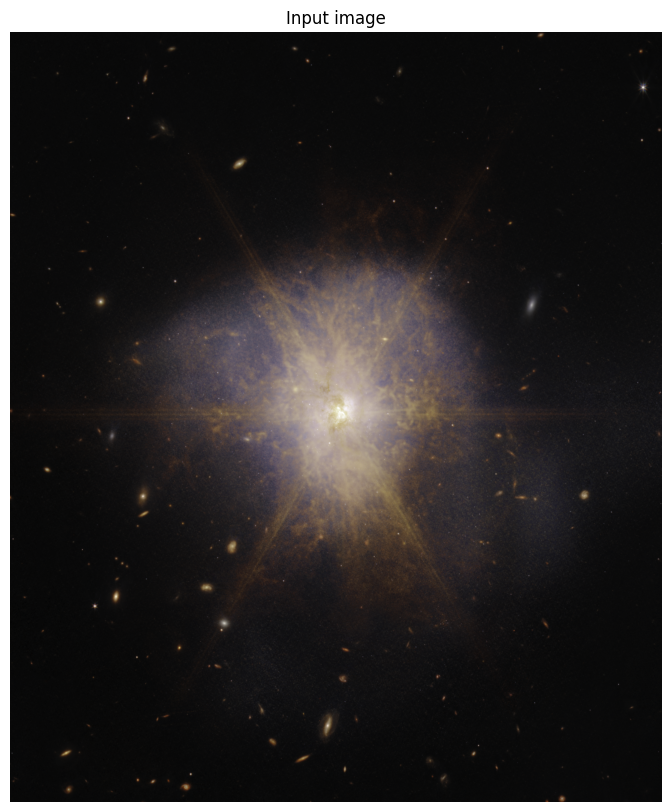

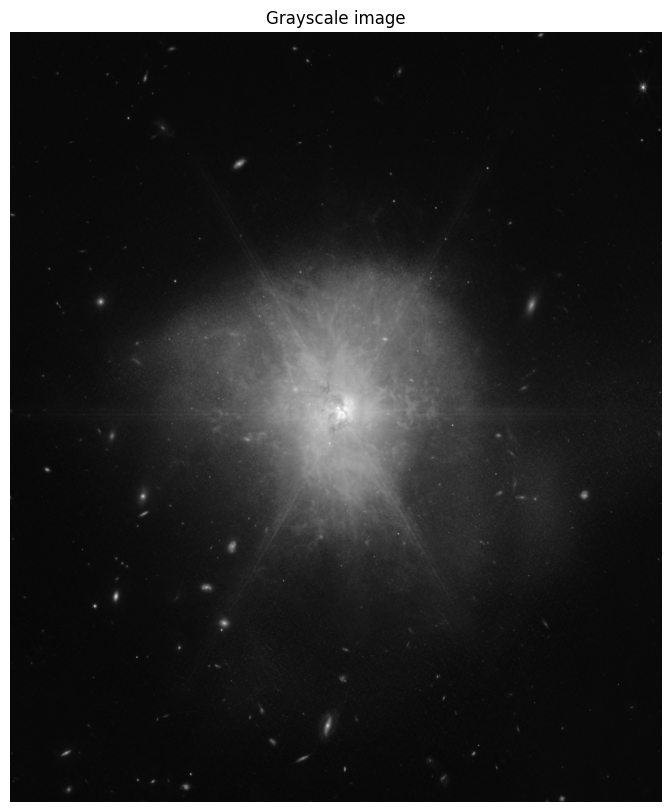

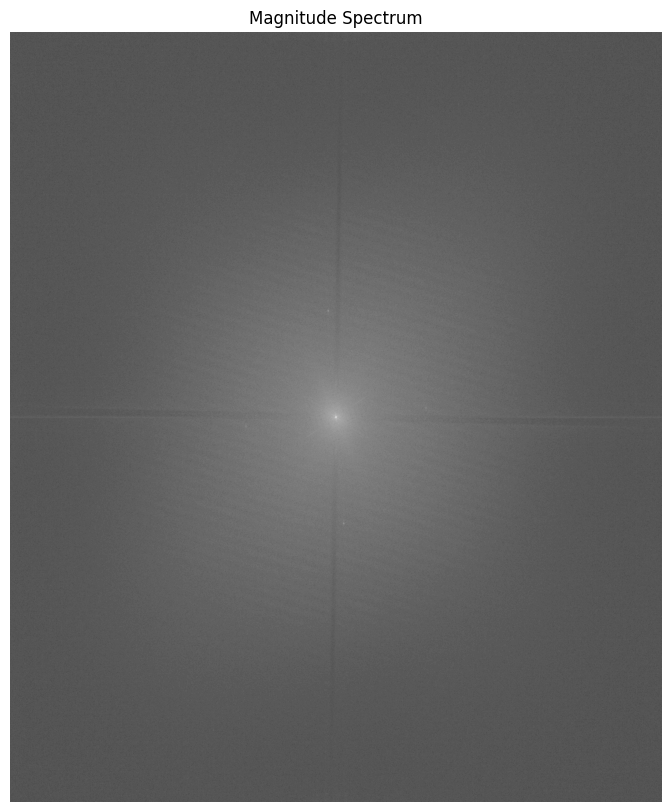

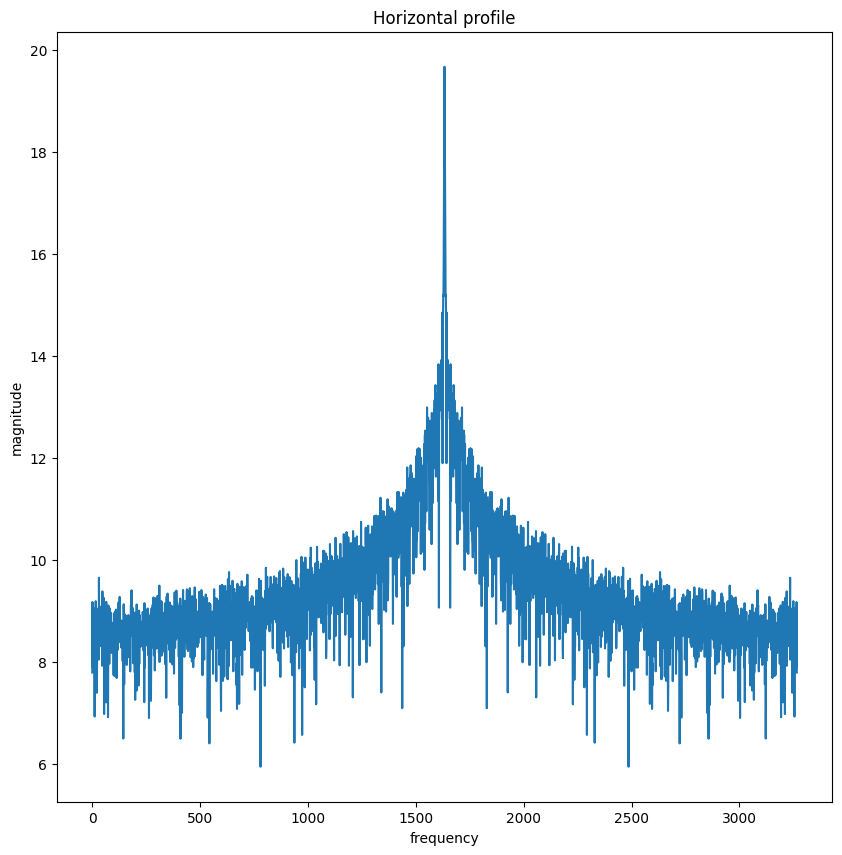

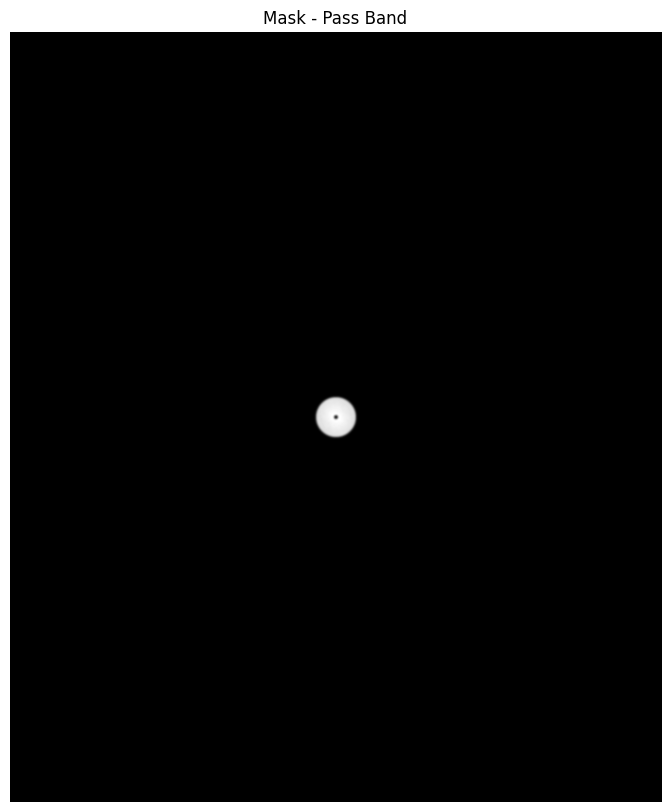

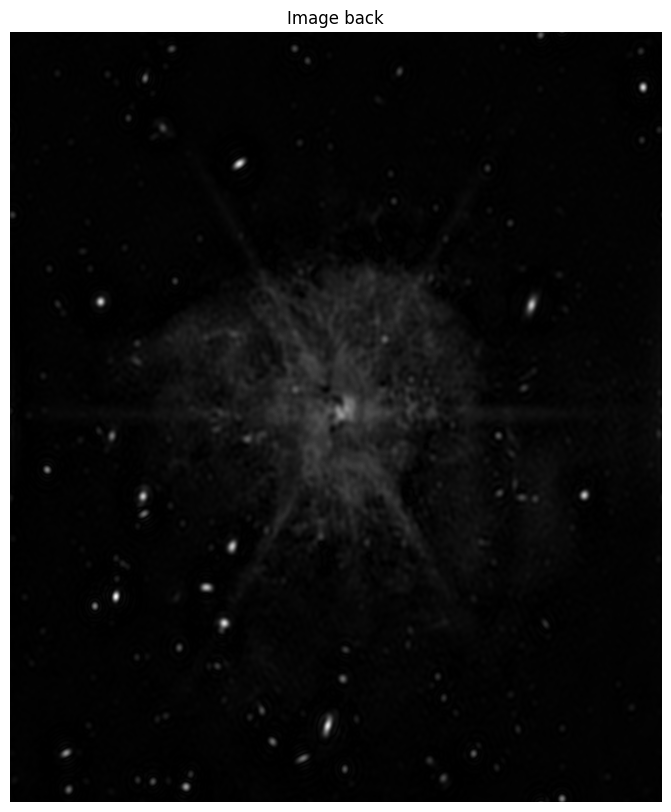

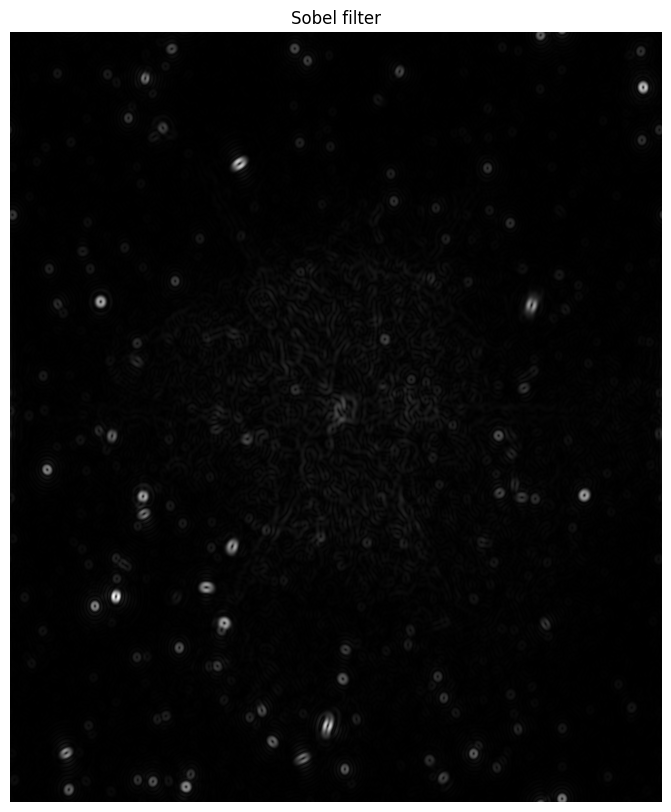

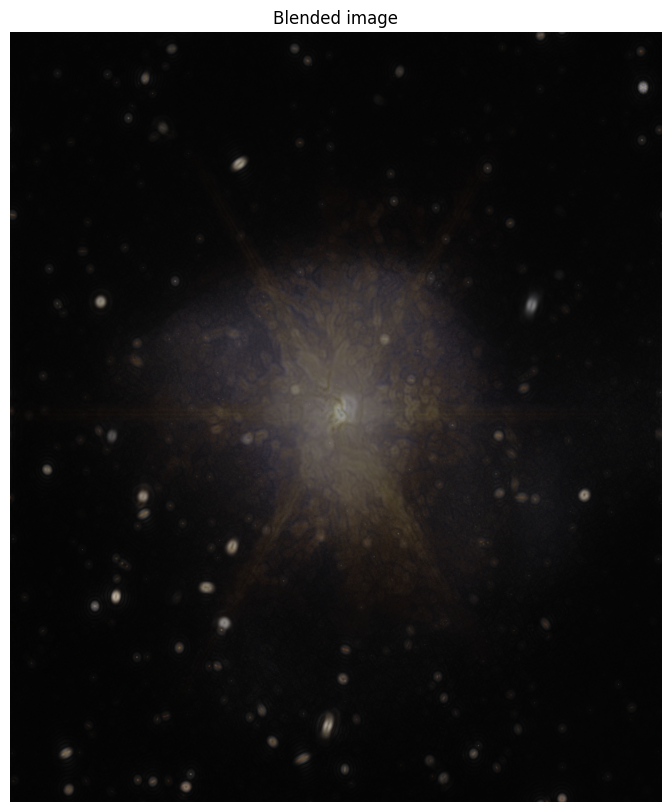

In [24]:
teste = Observar(img,f_max=100,f_min=10)
teste.pipeline()
